In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection

from evopipe import steps, evopipe

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = 'datasets/wilt-train.csv'

data = pd.read_csv(filename, sep=',')
train_X = data[data.columns[1:]]
train_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = train_Y.index
train_Y = pd.Series(le.fit_transform(train_Y), index=ix)


test_filename = 'datasets/wilt-test.csv'

data = pd.read_csv(test_filename, sep=',')
test_X = data[data.columns[1:]]
test_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = test_Y.index
test_Y = pd.Series(le.fit_transform(test_Y), index=ix)

params = steps.get_params(len(train_X.iloc[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, pipe_params, n_jobs=-1, verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC


KeyboardInterrupt: 

In [3]:
scorer = metrics.make_scorer(metrics.cohen_kappa_score, weights='quadratic')
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, ['featsel', 'scaling'], pop_size=300, ngen=30, mutpb=0.5, swap_mutpb=0.2,
                                param_mutpb=0.85, ind_mutpb=0.8, len_mutpb=0.5, scorer=scorer)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe, score in best_pipes:
    pipe.fit(train_X, train_Y)
    # res_Y = pipe.predict(test_X)
    
    # score = metrics.cohen_kappa_score(test_Y, res_Y, weights='quadratic')
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))

evaluating: [('kBest', OrderedDict([('k', 3), ('score_func', <function f_classif at 0x00000274848EB950>)]), 'featsel'), ('SGD', OrderedDict([('alpha', 0.01), ('epsilon', 0.1), ('eta0', 0.1), ('l1_ratio', 0.15), ('learning_rate', 'optimal'), ('loss', 'perceptron'), ('n_iter', 100), ('penalty', 'l2'), ('power_t', 0.1)]))]Evolution starting...
evaluating: [('SGD', OrderedDict([('alpha', 0.01), ('epsilon', 0.1), ('eta0', 0.1), ('l1_ratio', 0.15), ('learning_rate', 'optimal'), ('loss', 'perceptron'), ('n_iter', 100), ('penalty', 'l2'), ('power_t', 0.1)]))]
Gen 2:

evaluating: [('SVC', OrderedDict([('C', 10), ('gamma', 0.001), ('tol', 0.001)]))]
Gen 3:

evaluating: [('logR', OrderedDict([('C', 10), ('penalty', 'l2'), ('solver', 'sag'), ('tol', 0.0001)]))]
Gen 4:

evaluating: [('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.0001)]))]
Gen 5:

evaluating: [('kBest', OrderedDict([('k', 1), ('score_func', <function chi2 at 0x00000274848EBA60>)]), 'featsel'), ('gaussianNB', OrderedDict())]
Gen 

   	                        fitness                         	                  train_test                 
   	--------------------------------------------------------	---------------------------------------------
gen	var      	avg      	min         	max     	var       	avg     	min  	max  
0  	0.0537818	0.123027 	-0.0109479  	0.842969	0.00373133	0.644238	0.378	0.85 
1  	0.0894784	0.354288 	-0.000404858	0.842969	0.00650664	0.693913	0.404	0.85 
2  	0.0798773	0.398611 	0           	0.842969	0.00521858	0.704773	0.452	0.878
3  	0.0896489	0.380734 	0           	0.869122	0.00613399	0.70598 	0.532	0.862
4  	0.101355 	0.527916 	0           	0.869122	0.00893484	0.734533	0.412	0.862
5  	0.0676224	0.204448 	0           	0.869122	0.003599  	0.66694 	0.616	0.862
6  	0.0634923	0.24027  	0           	0.869122	0.00317398	0.661187	0.474	0.862
7  	0.080422 	0.192518 	0           	0.869122	0.00439705	0.66218 	0.626	0.862
8  	0.0777019	0.299887 	0           	0.894568	0.00688607	0.6642  	0.458	0.862
9  	0.

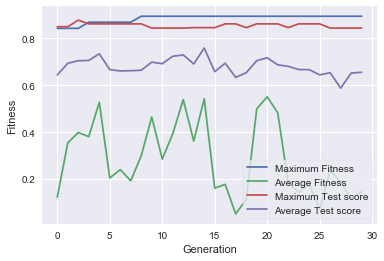

In [4]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, maxs, label='Maximum Fitness')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, avgs, label='Average Fitness')

line3 = ax1.plot(gen, maxs_tt, label='Maximum Test score')
line4 = ax1.plot(gen, avgs_tt, label='Average Test score')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
legend = plt.legend(lines, labels, loc='lower right', frameon=True)


plt.show()